In [4]:
# Cell 1: Imports & Parameters

import numpy as np
import pandas as pd
from pathlib import Path

import pvlib
from pvlib.iotools import read_epw
from pvlib.irradiance import get_total_irradiance
from pvlib.location import Location

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# 1) Paths & site info
project_root = Path.cwd().parent
epw_file     = project_root/"data"/"Bonfire_2025.epw"
assert epw_file.exists(), f"EPW not found: {epw_file}"

# 2) Grid settings
tilts = np.arange(0, 91, 5)      # 0°, 5°, …, 90°
azis  = np.arange(0, 361, 10)    # 0°, 10°, …, 360°

print("Tilt steps:", tilts)
print("Azimuth steps:", azis)
print("Using EPW:", epw_file)


Tilt steps: [ 0  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90]
Azimuth steps: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]
Using EPW: /Users/petertunali/Documents/GitHub/Battery_Optimisation/data/Bonfire_2025.epw


In [7]:
# Cell 2: Load EPW & Precompute Solar Position

from pvlib.iotools import read_epw
from pvlib.location import Location

# 1) Read EPW → weather DataFrame, metadata dict
weather, meta = read_epw(epw_file)

# 2) Site location & timezone
lat, lon = -37.304286, 145.695693
tz       = 'Australia/Melbourne'
site     = Location(lat, lon, tz=tz)

# 3) Time index (hourly)
times    = weather.index

# 4) Solar position & irradiance components
solpos = site.get_solarposition(times)

dni = weather['dni']
ghi = weather['ghi']
dhi = weather['dhi']

# 5) Time step in hours (should be 1h for EPW)
delta_h = (times[1] - times[0]).total_seconds() / 3600.0

print(f"Loaded {len(times)} hourly points; Δt = {delta_h} h")


Loaded 8760 hourly points; Δt = 1.0 h


In [8]:
# Cell 3: Grid-search Tilt & Azimuth

records = []
for tilt in tqdm(tilts, desc="Tilts"):
    for azi in azis:
        poa = get_total_irradiance(
            surface_tilt    = tilt,
            surface_azimuth = azi,
            solar_zenith    = solpos["zenith"],
            solar_azimuth   = solpos["azimuth"],
            dni             = dni,
            ghi             = ghi,
            dhi             = dhi
        )["poa_global"]
        # integrate to kWh/m²: W/m² × h → Wh/m² → kWh/m²
        annual_kwh = (poa * delta_h / 1000.0).sum()
        records.append((tilt, azi, annual_kwh))

res_df = pd.DataFrame(records, columns=["tilt","azimuth","yield_kwh"])


Tilts:   0%|          | 0/19 [00:00<?, ?it/s]

In [9]:
# Cell 4: Identify & Display Best Orientation

best = res_df.loc[res_df["yield_kwh"].idxmax()]
print("▶ Best tilt     = {:.1f}°".format(best.tilt))
print("▶ Best azimuth  = {:.1f}°".format(best.azimuth))
print("▶ Annual yield  = {:.1f} kWh/kWp".format(best.yield_kwh))


▶ Best tilt     = 30.0°
▶ Best azimuth  = 20.0°
▶ Annual yield  = 1726.0 kWh/kWp


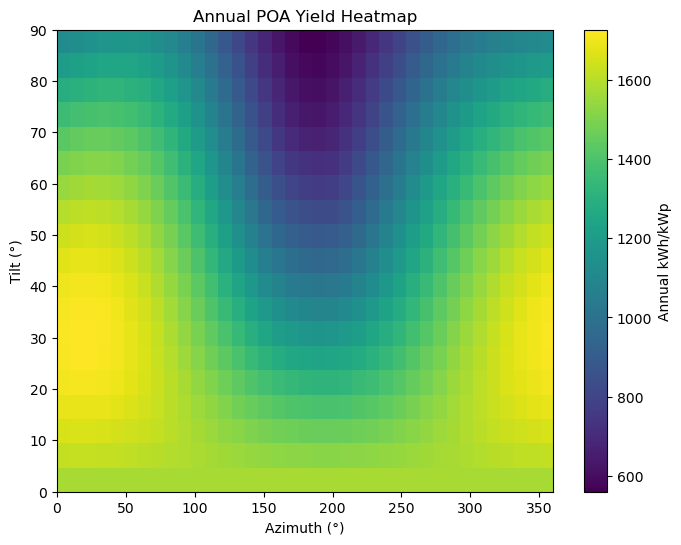

In [10]:
# Cell 5: Visualise as Heatmap

heat = res_df.pivot(index="tilt", columns="azimuth", values="yield_kwh")

plt.figure(figsize=(8,6))
plt.imshow(heat, origin="lower", aspect="auto",
           extent=[azis.min(),azis.max(),tilts.min(),tilts.max()])
plt.colorbar(label="Annual kWh/kWp")
plt.xlabel("Azimuth (°)")
plt.ylabel("Tilt (°)")
plt.title("Annual POA Yield Heatmap")
plt.show()
